# Interactive Tests of Python-Implemented Halo Exclusion

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First we set up the "test" as it were, hoping to do each case analytically if possible. We will use 

$$ n_g(m) = m^{-2}, $$
$$ I(m) = m^{-4}, $$
$$ b(m) = m^2 $$
$$ \Delta_h = 200, $$
$$ \rho_{mean} = 10^{11} $$

In [9]:
m = np.logspace(10,18,400)
density = m**-2
I = np.outer(np.ones(10),m**-4)
bias = m**2
deltah = 200.0
rhob = 10.**11
r = np.logspace(-1,2,40)

All the code here should be copy-pasted from the latest halo_exclusion module for quick updating. Throughout, we use a postfix underscore to indicate a jit-compiled function.

In [10]:
# Imports
import numpy as np
from hmf._framework import Model
from cached_property import cached_property
from scipy import integrate as intg
from numba import jit

## Tools

### Definitions

In [11]:
@jit
def outer(a,b):
    return np.outer(a,b).reshape(a.shape+b.shape)

def dblsimps(X,dx,dy=None):
    """
    Double-integral over the last two dimensions of X.
    """
    if dy is None:
        dy = dx

    if X.shape[-2]%2==0:
        X = X[...,:-1,:]
    if X.shape[-1]%2 == 0:
        X = X[...,:-1]

    (nx,ny) = X.shape[-2:]

    W = makeW(nx,ny)

    return dx * dy * np.sum(W * X,axis=(-2,-1)) / 9.0


def makeW(nx,ny):
    W = np.ones((nx,ny))
    W[1:nx-1:2, :] *= 4
    W[:, 1:ny-1:2] *= 4
    W[2:nx-1:2, :] *= 2
    W[:, 2:ny-1:2] *= 2
    return W
    
    
@jit(nopython=True)
def dblsimps_(X,dx,dy):
    """
    Double-integral of X.
    """
    nx = X.shape[0]
    ny = X.shape[1]

    # Must be odd number
    if nx%2==0:
        nx -= 1
    if ny%2==0:
        ny -= 1
        
    W = makeW_(nx,ny) #only upper
    
    tot=0.0
    for ix in range(nx):
        tot += W[ix,ix]*X[ix,ix]
        for iy in range(ix+1,ny):
            tot += 2*W[ix,iy] * X[ix,iy]
            
    return dx * dy * tot / 9.0

@jit(nopython=True)
def makeW_(nx,ny):
    W = np.ones((nx,ny))
    for ix in range(1,nx-1,2):
        for iy in range(ny):
            W[ix,iy] *= 4
            W[iy,ix] *= 4
                        
    for ix in range(2,nx-1,2):
        for iy in range(ny):
            W[ix,iy] *= 2
            W[iy,ix] *= 2
            
    return W

### Accuracy Tests

In [9]:
# Test simple integration, output should be [0,0.25,4.0,20.25]
a = np.zeros((4,101,101))
for i in range(4):
    a[i,:,:] = np.outer(np.linspace(0,i,101),np.linspace(0,i,101))
dblsimps(a,arange(4)/100.,arange(4)/100.)

array([  0.  ,   0.25,   4.  ,  20.25])

In [10]:
for i in range(4):
    a = np.outer(np.linspace(0,i,101),np.linspace(0,i,101))
    print dblsimps_(a,i/100.,i/100.)

0.0
0.25
4.0
20.25


### Timing

In [11]:
%timeit makeW(501,501)
%timeit makeW_(501,501)

1000 loops, best of 3: 1.42 ms per loop
1000 loops, best of 3: 1.13 ms per loop


In [12]:
a = np.outer(np.linspace(0,1,501),np.linspace(0,1,501))
%timeit dblsimps(a,0.002,0.002)
%timeit dblsimps_(a,0.002,0.002)


100 loops, best of 3: 1.97 ms per loop


KeyboardInterrupt: 

## Base Class

In [27]:
class Exclusion(Model):
    """
    Base class for exclusion models.
    
    All models will need to perform single or double integrals over
    arrays that may have an extra two dimensions. The maximum possible
    size is k*r*m*m, which for normal values of the vectors equates to
    ~ 1000*50*500*500 = 12,500,000,000 values, which in 64-bit reals is
    1e11 bytes = 100GB. We thus limit this to a maximum of either k*r*m 
    or r*m*m, both of which should be less than a GB of memory. 
    
    It is possibly better to limit it to k*r or m*m, which should be quite 
    memory efficient, but then without accelerators (ie. Numba), these
    will be very slow. 
    """
    def __init__(self,m,density,I,bias,r,delta_halo,mean_density):
        self.density = density  # 1d, (m)
        self.m = m              # 1d, (m)
        self.I = I              # 2d, (k,m)
        self.bias = bias        # 1d (m) or 2d (r,m)
        self.r = r              # 1d (r)
        
        self.mean_density = mean_density
        self.delta_halo=delta_halo
        self.dlnx = np.log(m[1]/m[0])

    def raw_integrand(self):
        """
        Returns either a 2d (k,m) or 3d (r,k,m) array with the general integrand.
        """
        if len(self.bias.shape)==1:
            return self.I * self.bias * self.m # *m since integrating in logspace
        else:
            return np.einsum("ij,kj->kij",self.I*self.m,self.bias)

    def integrate(self):
        """
        This should pass back whatever is multiplied by P_m(k) to get the two-halo
        term. Often this will be a square of an integral, sometimes a Double-integral.
        """
        pass

## No exclusion

### Definition

In [28]:
class NoExclusion(Exclusion):
    def integrate(self):
        return intg.simpson(self.raw_integrand(),dx=self.dlnx)**2

### Analytic Case
The integral in this case should simply be

$$ P(k) = P_m(k) \left[\int_{10^{10}}^{10^{18}} m^{-4} m^2 dm \right]^2  \approx 10^{-20} $$

### Numerical Test

In [ ]:
cls = NoExclusion(m,density,I,bias,None,deltah,rhob)
cls.integrate()[0]

### Timing

In [ ]:
%timeit cls.integrate()

## Sphere

Again, we should not need to jit-compile anything in this case, since we can do everything with broadcasting in Numpy without too much memory overhead.

In [45]:
class Sphere(Exclusion):
    def raw_integrand(self):
        if len(self.bias.shape)==1:
            return outer(np.ones_like(self.r),self.I * self.bias * self.m) # *m since integrating in logspace
        else:
            return np.einsum("ij,kj->kij",self.I*self.m,self.bias)
        
    @cached_property
    def density_mod(self):
        """
        Return the modified density, under new limits
        """
        density = np.outer(np.ones_like(self.r),self.density*self.m)
        density[self.mask] = 0
        if hasattr(self.m,"unit"):
            return intg.simpson(density,dx=self.dlnx)*self.m.unit*self.density.unit
        else:
            return intg.simpson(density,dx=self.dlnx)
    @cached_property
    def mask(self):
        "Elements that should be set to 0"
        return (np.outer(self.m,np.ones_like(self.r)) > self.mlim().value).T

    def mlim(self):
        return 4*np.pi*(self.r/2)**3 * self.mean_density * self.delta_halo/3

    def integrate(self):
        integ = self.raw_integrand() #r,k,m
        integ.transpose((1,0,2))[:,self.mask] = 0
        return intg.simpson(integ,dx=self.dlnx)**2

### Analytic Case

In this case, the limit of the integral changes, and we should have 

$$ P(k) = P_m(k) \left[\int_{10^{10}}^{m_{lim}} m^{-4} m^2 dm \right]^2  = \left(10^{-10} - 1/m_{lim}\right)^2, $$

with 

$$ m_{lim} = \frac{4\pi \Delta_h \bar{\rho}}{3} (r/2)^3. $$

At about $r = 0.1$, we have $m_{lim} \approx 10^{10}$, and so the result should drop to zero.

### Numerical Test

In [ ]:
cls = Sphere(m,density,I,bias,r,deltah,rhob)

In [ ]:
mlim = 4*pi*(r/2)**3 *deltah *rhob/3
analytic = (1e-10 - 1./mlim)**2
fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2.5,1)})
ax[0].plot(r,cls.integrate()[:,0])
ax[0].plot(r,analytic)
ax[1].plot(r,cls.integrate()[:,0]/analytic)

### Timing

In [ ]:
%timeit cls.integrate()

## DblSphere

In this case, we'll need to use some acceleration, since otherwise at one point we need an ``(r,k,m,m)`` matrix which is too big.

In [46]:
class DblSphere(Sphere):
    @property
    def rvir(self):
        return (3*self.m/(4*np.pi*self.delta_halo*self.mean_density))**(1./3.)

    @cached_property
    def mask(self):
        "Elements that should be set to 0 (r,m,m)"
        rvir = self.rvir
        return (outer(np.add.outer(rvir,rvir),np.ones_like(self.r)) > self.r).T

    def density_mod(self):
        out = np.zers_like(self.r)
        for i,r in enumerate(self.r):
            integrand = np.outer(self.density*self.m,np.ones_like(self.density))
            integrand[self.mask] = 0
            out[i] = dblsimps(integrand,self.dlnx)
        if hasattr(self.m,"unit"):
            return out*self.m.unit*self.density.unit
        else:
            return out
    def integrate(self):
        integ = self.raw_integrand() #(r,k,m)
        return integrate_dblsphere(integ,self.mask,self.dlnx)
    
def integrate_dblsphere(integ,mask,dx):
    out = np.zeros_like(integ[:,:,0])
    integrand = np.zeros_like(mask)
    for ik in range(integ.shape[1]):
        for ir in range(mask.shape[0]):
            integrand[ir] = np.outer(integ[ir,ik,:],integ[ir,ik,:])
        integrand[mask] = 0
        out[:,ik] = dblsimps(integrand,dx)
    return out

##### ACCELERATED METHODS

@jit(nopython=True)
def integrate_dblsphere_(integ,mask,dx):
    nr = integ.shape[0]
    nk = integ.shape[1]
    nm  = mask.shape[1]
    
    out = np.zeros((nr,nk))
    integrand = np.zeros((nm,nm))

    for ir in range(nr):
        for ik in range(nk):
            for im in range(nm):
                for jm in range(im,nm):
                    if mask[ir,im,jm]:
                        integrand[im,jm] = 0
                    else:
                        integrand[im,jm] = integ[ir,ik,im]*integ[ir,ik,jm]

#             if ir==0 and ik==0:
#                 print np.sum(integrand)
            out[ir,ik] = dblsimps_(integrand,dx,dx)
    return out

class DblSphere_(DblSphere):
    def integrate(self):
        integ = self.raw_integrand() #(r,k,m)
        return integrate_dblsphere_(integ,self.mask,self.dlnx)

### Analytic Case

The precise analytic case is difficult here, owing to the double-integral etc. Basically, we get:

$$ P(k,r)/P_m(k) = 10^{-10}\left(10^{-10} - 1/m_{lim}\right) - \int_{10^{10}}^{m_{lim}} \left[m^{2/3} \left(\frac{4\pi \Delta_h \bar{\rho}}{3}\right)^{1/3} r - m\right]^{-3} dm $$

The first term is similar to the single-integral sphere case, but here 

$$ m_{lim} = \frac{4\pi \Delta_h \bar{\rho}}{3}r^3 $$

and we have the second term as well. The second term becomes undefined when $m = m_{lim}$. 

This has an exact solution, but for these purposes, its probably just easier to do it numerically:

In [17]:
anl = np.zeros_like(r)
for ir, rr in enumerate(r):
    mlim = 4*np.pi*rhob*deltah*rr**3/3
    anl[ir] = 10**-10*(10**-10 - 1/mlim) - intg.simpson((m[m<mlim]**(2./3.)*(4*np.pi*deltah*rhob/3)**(1./3.) * rr - m[m<mlim])**-3,x=m[m<mlim])

### Numerical Test

In [ ]:
anl

In [ ]:
cls = DblSphere(m,density,I,bias,r,deltah,rhob)
cls_ = DblSphere_(m,density,I,bias,r,deltah,rhob)

py = cls.integrate()[:,0]
nba = cls_.integrate()[:,0]

fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2.5,1)})
ax[0].plot(r,py,label="python")
ax[0].plot(r,nba,label="numba")
#ax[0].plot(r,anl,label="analytic")
ax[0].legend(loc=0)

ax[1].plot(r,py/anl)
ax[1].plot(r,nba/anl)

### Timing

In [ ]:
%timeit cls.integrate()
%timeit cls_.integrate()

## Ellipsoid

This case is similar to ``DblSphere``, except that we integrate to infinity, with a well-behaved probability distribution tailing to zero. 

In [57]:
class DblEllipsoid(DblSphere):
    @cached_property
    def mask(self):
        "Unecessary for this approach"
        return None

    @cached_property
    def prob(self):
        rvir = self.rvir
        x = outer(self.r,1/np.add.outer(rvir,rvir))
        x = (x-0.8)/0.29 #this is y but we re-use the memory
        np.clip(x,0,1,x)
        return  3*x**2 - 2*x**3

    @cached_property
    def density_mod(self):
        integrand = self.prob * outer(np.ones_like(self.r),np.outer(self.density*self.m,self.density*self.m))
        a = np.sqrt(dblsimps(integrand,self.dlnx))
        if hasattr(self.density,"unit"):
            return a*self.density.unit*self.m.unit
        else:
            return a
        
    def integrate(self):
        integ = self.raw_integrand() #(r,k,m)
        out = np.zeros_like(integ[:,:,0])

        integrand = np.zeros_like(self.prob)
        for ik in range(integ.shape[1]):

            for ir in range(len(self.r)):
                integrand[ir] = self.prob[ir]*np.outer(integ[ir,ik,:],integ[ir,ik,:])
            out[:,ik] = dblsimps(integrand,self.dlnx)
        return out



class DblEllipsoid_(DblEllipsoid):
    @cached_property
    def density_mod(self):
        if hasattr(self.density,"unit"):
            return density_mod_(self.r,self.rvir,np.outer(self.density*self.m,self.density*self.m),self.dlnx)*self.density.unit*self.m.unit
        else:
            return density_mod_(self.r,self.rvir,np.outer(self.density*self.m,self.density*self.m),self.dlnx)
    @cached_property
    def prob(self):
        return prob_inner_(self.r,self.rvir)

    def integrate(self):
        return integrate_dblell(self.raw_integrand(),self.prob,self.dlnx)

@jit(nopython=True)
def integrate_dblell(integ,prob,dx):
    nr = integ.shape[0]
    nk = integ.shape[1]
    nm  = prob.shape[1]

    out = np.zeros((nr,nk))
    integrand = np.zeros((nm,nm))

    for ir in range(nr):
        for ik in range(nk):
            for im in range(nm):
                for jm in range(im,nm):
                    integrand[im,jm] = integ[ir,ik,im]*integ[ir,ik,jm]*prob[ir,im,jm]
            out[ir,ik] = dblsimps_(integrand,dx,dx)
    return out

@jit(nopython=True)
def density_mod_(r,rvir,densitymat,dx):
    d = np.zeros(len(r))
    for ir,rr in enumerate(r):
        integrand = prob_inner_r_(rr,rvir)*densitymat
        d[ir] = dblsimps_(integrand,dx,dx)
    return np.sqrt(d)

@jit(nopython=True)
def prob_inner_(r,rvir):
    """
    Jit-compiled version of calculating prob, taking advantage of symmetry.
    """
    nrv = len(rvir)
    out = np.empty((len(r),nrv,nrv))
    for ir,rr in enumerate(r):
        for irv, rv1 in enumerate(rvir):
            for jrv in range(irv,nrv):
                rv2 = rvir[jrv]
                x = (rr/(rv1+rv2) - 0.8)/0.29
                if x<=0:
                    out[ir,irv,jrv] = 0
                elif x>=1:
                    out[ir,irv,jrv] = 1
                else:
                    out[ir,irv,jrv] = 3*x**2 - 2*x**3
    return out
            
@jit(nopython=True)
def prob_inner_r_(r,rvir):
    nrv = len(rvir)
    out = np.empty((nrv,nrv))
    for irv, rv1 in enumerate(rvir):
        for jrv in range(irv,nrv):
            rv2 = rvir[jrv]
            x = (r/(rv1+rv2) - 0.8)/0.29
            if x<=0:
                out[irv,jrv] = 0
            elif x>=1:
                out[irv,jrv] = 1
            else:
                out[irv,jrv] = 3*x**2 - 2*x**3
    return out


### Analytic Case

This is unsolvable analytically because of $P(x)$. Indeed, the closest we can really get is

$$ P(k,r)/P_m(k) = \int \int \frac{P(m_1,m_2,r)}{m_1^2 m_2^2} dm_1 dm_2 $$

To have some measure of comparison, let's write a function to integrate with ``dblquad``:

In [19]:
def integrand_log(m1,m2,r):
    rvir1 = (3*10**m1/(4*np.pi*deltah*rhob))**(1./3.)
    rvir2 = (3*10**m2/(4*np.pi*deltah*rhob))**(1./3.)
    x = r/(rvir1+rvir2)
    y = (x-0.8)/0.29
    if y<=0:
        p = 0.0
    elif y>=1:
        p = 1.0
    else:
        p = 3*y**2-2*y**3
    #print rvir1, rvir2, x, y, p
    return p/(10**(m1) * 10**(m2))

from scipy.integrate import dblquad

In [81]:
anl_dblell = np.array([np.log(10)**2*dblquad(integrand_log,10,18,lambda x: 10, lambda x: 18,args=(rr,))[0] for rr in r])

### Numerical Test

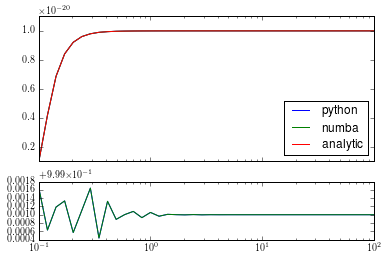

In [21]:
cls = DblEllipsoid(m,density,I,bias,r,deltah,rhob)
cls_ = DblEllipsoid_(m,density,I,bias,r,deltah,rhob)

py = cls.integrate()[:,0]
nba = cls_.integrate()[:,0]

fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2.5,1)})
ax[0].plot(r,py,label="python")
ax[0].plot(r,nba,label="numba")
ax[0].plot(r,anl_dblell,label="analytic")
ax[0].legend(loc=0)

ax[1].plot(r,py/anl_dblell)
ax[1].plot(r,nba/anl_dblell)

### Timing

In [ ]:
%timeit cls.integrate()
%timeit cls_.integrate()

## Ng-Matched

In [58]:
class NgMatched(DblEllipsoid):
    @cached_property
    def mask(self):
        integrand = self.density*self.m
        cumint = intg.cumtrapz(integrand,dx=self.dlnx,initial=0) #len m
        cumint = np.outer(np.ones_like(self.r),cumint) # r,m
        return np.where(cumint>np.outer(self.density_mod,np.ones_like(self.m)),
                        np.ones_like(cumint,dtype=bool),np.zeros_like(cumint,dtype=bool))

    def integrate(self):
        integ = self.raw_integrand() #r,k,m
        integ.transpose((1,0,2))[:,self.mask] = 0
        return intg.simpson(integ,dx=self.dlnx)**2


class NgMatched_(DblEllipsoid_):
    @cached_property
    def mask(self):
        integrand = self.density*self.m
        cumint = intg.cumtrapz(integrand,dx=self.dlnx,initial=0) #len m
        cumint = np.outer(np.ones_like(self.r),cumint) # r,m
        return np.where(cumint>np.outer(self.density_mod,np.ones_like(self.m)),
                        np.ones_like(cumint,dtype=bool),np.zeros_like(cumint,dtype=bool))

    def integrate(self):
        integ = self.raw_integrand() #r,k,m
        integ.transpose((1,0,2))[:,self.mask] = 0
        return intg.simps(integ,dx=self.dlnx)**2

### Analytic Case

In essense, this is the same as the single-integral sphere case, so that the result is

$$ P(k,r)/P_m(k) = \left[10^{-10} - 1/m_{lim}\right]^2, $$

but in this case $m_{lim}$ is defined slightly differently:

$$ \int_{10^{10}} ^ {m_{lim}} m^{-2} dm = \sqrt{\int \int \frac{P(x)}{m_1^2 m_2^2} dm_1 dm_2}. $$

We can simplify to 

$$ m_{lim} = \frac{1}{10^{-10} - \sqrt{b_{eff}^{\rm dbl}}}, $$

where $b_{eff}^{\rm dbl}$ is merely the result from the ``DblEllipsoid`` class. Popping this back into the solution cancels everything so we're left with

$$ P(k,r)/P_m(k) \equiv b_{eff}^{\rm ngm}= b_{eff}^{\rm dbl}. $$

Note that this is only the case exactly because the density integrand and full integrand are exactly the same.

### Numerical Test

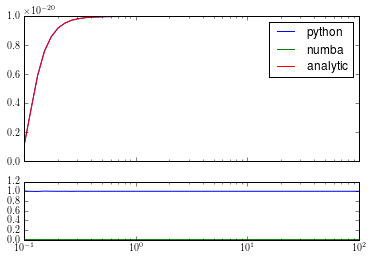

In [82]:
cls = NgMatched(m,density,I,bias,r,deltah,rhob)
cls_ = NgMatched_(m,density,I,bias,r,deltah,rhob)

py = cls.integrate()[:,0]
nba = cls_.integrate()[:,0]

fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2.5,1)})
ax[0].plot(r,py,label="python")
ax[0].plot(r,nba,label="numba")
ax[0].plot(r,anl_dblell,label="analytic")
ax[0].legend(loc=0)

ax[1].plot(r,py/anl_dblell)
ax[1].plot(r,nba/anl_dblell)

### Timing

In [83]:
%timeit cls.integrate()
%timeit cls_.integrate()

1 loops, best of 3: 416 ms per loop
1 loops, best of 3: 444 ms per loop


## Comparison

### Visual

In [ ]:
fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2,1)},figsize=(8,8))

for cls in (Sphere,DblSphere_,DblEllipsoid_,NgMatched):
    vec = cls(m,density,I,bias,r,deltah,rhob).integrate()[:,0]
    ax[0].plot(r,vec,label=cls.__name__.replace("_",""))
    ax[1.].plot(r,vec/anl_dblell)

ax[0].legend(loc=0)

### Timing

For this bit, we increase the numbers of elements of the arrays to reasonable amounts:

In [84]:
m = np.logspace(10,18,650)
density = m**-2
I = np.outer(np.ones(550),m**-4)
bias = m**2
deltah = 200.0
rhob = 10.**11
r = np.logspace(-1,2,50)

In [85]:
# For reference, ng_matched fortran does it in ~300ms
%timeit NoExclusion(m,density,I,bias,r,deltah,rhob).integrate()
%timeit Sphere(m,density,I,bias,r,deltah,rhob).integrate()
#%timeit DblSphere(m,density,I,bias,r,deltah,rhob).integrate()
#%timeit DblSphere_(m,density,I,bias,r,deltah,rhob).integrate()
#%timeit DblEllipsoid(m,density,I,bias,r,deltah,rhob).integrate()
#%timeit DblEllipsoid_(m,density,I,bias,r,deltah,rhob).integrate()
%timeit NgMatched(m,density,I,bias,r,deltah,rhob).integrate()
%timeit NgMatched_(m,density,I,bias,r,deltah,rhob).integrate()

100 loops, best of 3: 5.1 ms per loop
1 loops, best of 3: 385 ms per loop
1 loops, best of 3: 1.77 s per loop
1 loops, best of 3: 1.02 s per loop


## Ogata Method

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline as spline

def power_to_corr(r,power,lnk,N=640,h=0.005):
    """
    Use Ogata's method for Hankel Transforms in 3D for nu=0 (nu=1/2 for 2D)
    to convert a given power spectrum to a correlation function.

    Note, in its current form, lnk must be evenly-spaced.
    """
    spl = spline(lnk,power)
    roots=np.arange(1,N+1)
    t = h*roots
    s = np.pi*np.sinh(t)
    x = np.pi * roots * np.tanh(s/2)

    dpsi = 1+np.cosh(s)
    dpsi[dpsi!=0] = (np.pi*t*np.cosh(t)+np.sinh(s))/dpsi[dpsi!=0]
    sumparts = np.pi*np.sin(x)*dpsi*x

    allparts = sumparts * spl(np.log(np.divide.outer(x,r))).T
    return np.sum(allparts,axis=-1)/(2*np.pi**2*r**3)

In [ ]:
from halomod.tools import power_to_corr_ogata
from hmf import Transfer

In [ ]:
t = Transfer()
xir = power_to_corr(r,t.power,np.log(t.k.value))
xir_fort = power_to_corr_ogata(t.power,t.k,r)
print xir/xir_fort-1

In [ ]:
def power_to_corr_matrix(r,power,lnk,N=640,h=0.005):
    """
    Use Ogata's method for Hankel Transforms in 3D for nu=0 (nu=1/2 for 2D)
    to convert a given power spectrum to a correlation function.

    In this case, `power` is a (k,r) matrix
    """
    roots=np.arange(1,N+1)
    t = h*roots
    s = np.pi*np.sinh(t)
    x = np.pi * roots * np.tanh(s/2)

    dpsi = 1+np.cosh(s)
    dpsi[dpsi!=0] = (np.pi*t*np.cosh(t)+np.sinh(s))/dpsi[dpsi!=0]
    sumparts = np.pi*np.sin(x)*dpsi*x    
    
    out = np.zeros_like(r)
    for ir,rr in enumerate(r):
        spl = spline(lnk,power[:,ir])
        allparts = sumparts * spl(np.log(x/rr))
        out[ir] = np.sum(allparts)/(2*np.pi**2*rr**3)
    return out

In [ ]:
pow2 = np.repeat(t.power,len(r)).reshape((-1,len(r)))
xir2 = power_to_corr_matrix(r,pow2,np.log(t.k.value))
print xir2/xir_fort

In [ ]:
%timeit power_to_corr_matrix(r,pow2,np.log(t.k.value))
%timeit power_to_corr(r,t.power,np.log(t.k.value))

## Full 2-halo Term

In [37]:
from halomod import halo_model
from halomod.fort.routines import hod_routines as fort
from scipy.integrate import trapz,simps
from halomod.twohalo_wrapper import twohalo_wrapper as thalo

In [3]:
h = halo_model.HaloModel(rnum=50,dlog10m=0.03)

In [41]:
def fortran_2halo():       
    u = h.profile.u(h.k, h.M , norm='m')
    return thalo("ng_matched", True,
                 h.M.value, h.bias, h.n_tot,
                 h.dndm.value, np.log(h.k.value),
                 h._power_halo_centres.value, u, h.r.value, h.corr_mm_base,
                 h.mean_gal_den.value, h.delta_halo,
                 h.mean_density.value, h.nthreads_2halo)

In [52]:
from halomod import tools
def python_2halo():
    ### POWER PART
    u = h.profile.u(h.k,h.M,norm="m")
    if h.scale_dependent_bias is not None:
        bias = np.outer(h.sd_bias.bias_scale(),h.bias)
    else:
        bias = h.bias
    inst = NgMatched_(m=h.M,density=h.n_tot*h.dndm,
                  I=h.n_tot*h.dndm*u/h.mean_gal_den,
                  bias=bias,r=h.r,delta_halo=h.delta_halo,
                  mean_density=h.mean_density)

    if hasattr(inst,"density_mod"):
        __density_mod = inst.density_mod
    else:
        __density_mod = h.mean_gal_den

    power_gg_2h= inst.integrate() * h._power_halo_centres

    if len(power_gg_2h.shape)==2:
        corr = tools.power_to_corr_ogata_matrix(power_gg_2h,h.k.value,h.r)
    else:
        corr = tools.power_to_corr_ogata(power_gg_2h,h.k.value,h.r)

    print __density_mod/h.mean_gal_den
    ## modify by the new density
    return (__density_mod/h.mean_gal_den)**2 * (1+corr)-1

### Visual

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.03116097  0.16901763  0.34861526  0.4966459
  0.60185108  0.67785585  0.73538611  0.78137747  0.82005801  0.85384447
  0.88395688  0.91082625  0.93439405  0.95435384  0.97038116  0.98234871
  0.99048493  0.99541048  0.99800851  0.99917913  0.99962093  0.99975653
  0.9997886   0.99979395  0.99979452  0.99979455  0.99979455  0.99979455
  0.99979455  0.99979455  0.99979455  0.99979455  0.99979455  0.99979455
  0.99979455  0.99979455  0.99979455  0.99979455  0.99979455  0.99979455
  0.99979455]


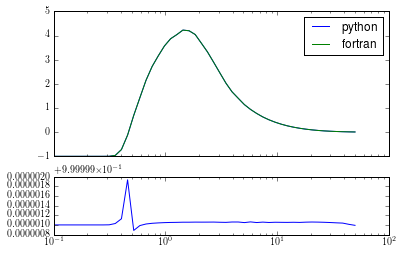

In [59]:
py = python_2halo()
fort = fortran_2halo()

fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2.5,1)})
ax[0].plot(h.r,py,label="python")
ax[0].plot(h.r,fort,label="fortran")
#ax[0].plot(r,anl,label="analytic")
ax[0].legend(loc=0)

ax[1].plot(h.r,py/fort)